### Basic neural activity analysis with single camera tracking
#### analyze the firing rate PC1,2,3
#### making the demo videos
#### analyze the spike triggered pull and gaze ditribution
#### the following detailed analysis focused on pull related behavioral events

In [150]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from dPCA import dPCA
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests


### function - get body part location for each pair of cameras

In [151]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [152]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [153]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [154]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [155]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [156]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam import plot_continuous_bhv_var_singlecam
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [157]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [158]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [159]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [160]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [161]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [162]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [349]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                0.00,
                                79.0,
                                162.6,
                                231.9,
                              ] # in second
        kilosortvers = [ 
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,

                            4,
                            4,
                            4,
                            
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
                            4,
            
                            4,
                            4,    
                            4,
                            4,
                            4,
                            4,
                            4,
            
                            4,
                            4,
                            4,
                            4,
                            4,
                       ]
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                              ] # in second
        kilosortvers = [
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
            
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         
                         4,
                         4,
                         4,
                         4,
                         4,
                        ]
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson",
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])

pull_trig_events_all_dates = dict.fromkeys(dates_list, [])

spike_trig_events_all_dates = dict.fromkeys(dates_list, [])

bhvevents_aligned_FR_all_dates = dict.fromkeys(dates_list, [])
bhvevents_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])

strategy_aligned_FR_all_dates = dict.fromkeys(dates_list, [])
strategy_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])

# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [350]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull_trig_events_all_dates = pickle.load(f)    
    
    with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        spike_trig_events_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/bhvevents_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_allevents_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/strategy_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        strategy_aligned_FR_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/strategy_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        strategy_aligned_FR_allevents_all_dates = pickle.load(f) 
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # successful trial or not
        succtrial_ornot = np.array((trial_record['rewarded']>0).astype(int))
        succpull1_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==1]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpull2_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==2]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpulls_ornot = [succpull1_ornot,succpull2_ornot]
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        if 0: # old definition; not in use
            trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
            bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
            #
            time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
            time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
            time_point_pull1_succ = np.round(time_point_pull1_succ,1)
            time_point_pull2_succ = np.round(time_point_pull2_succ,1)
            #
            trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
            bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
            #
            time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
            time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
            time_point_pull1_fail = np.round(time_point_pull1_fail,1)
            time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        else:
            # a new definition of successful and failed pulls
            # separate successful and failed pulls
            # step 1 all pull and juice
            time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
            time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
            time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
            time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
            # step 2:
            # pull 1
            # Find the last pull before each juice
            successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
            # Convert to Pandas Series
            successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
            # pull 2
            # Find the last pull before each juice
            successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
            # Convert to Pandas Series
            successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
            #
            # step 3:
            time_point_pull1_succ = np.round(successful_pull1,1)
            time_point_pull2_succ = np.round(successful_pull2,1)
            time_point_pull1_fail = np.round(failed_pull1,1)
            time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
            
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, totalsess_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, totalsess_time, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

     
        
        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 0:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        
        # plot key continuous behavioral variables
        if 1:
            filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+cameraID+'/'+date_tgt+'/'
            if not os.path.exists(filepath_cont_var):
                os.makedirs(filepath_cont_var)

            savefig = 1
            
            aligntwins = 4 # 5 second
            
            min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording

            pull_trig_events_summary, _, _ = plot_continuous_bhv_var_singlecam(filepath_cont_var+date_tgt+cameraID,
                                    aligntwins, savefig, animal1, animal2, 
                                    session_start_time, min_length, succpulls_ornot, time_point_pull1, time_point_pull2, 
                                    oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                    output_look_ornot, output_allvectors, output_allangles,output_key_locations)
            pull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            
                
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)
            # behavioral events aligned firing rate for each unit
            if 1: 
                print('plot event aligned firing rate')
                #
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+\
                            animal1_filename+"_"+animal2_filename+'_'+recordedanimal+'Recorded'+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                bhvevents_aligned_FR_average_all,bhvevents_aligned_FR_allevents_all = plot_bhv_events_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                bhvevents_aligned_FR_all_dates[date_tgt] = bhvevents_aligned_FR_average_all
                bhvevents_aligned_FR_allevents_all_dates[date_tgt] = bhvevents_aligned_FR_allevents_all
                
            
            # the three strategy aligned firing rate for each unit
            if 1: 
                print('plot strategy aligned firing rate')
                #
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+\
                            animal1_filename+"_"+animal2_filename+'_'+recordedanimal+'Recorded'+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                stg_twins = 1.5 # 3s, the behavioral event interval used to define strategy, consistent with DBN 3s time lags
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                strategy_aligned_FR_average_all,strategy_aligned_FR_allevents_all = plot_strategy_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,stg_twins,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                strategy_aligned_FR_all_dates[date_tgt] = strategy_aligned_FR_average_all
                strategy_aligned_FR_allevents_all_dates[date_tgt] = strategy_aligned_FR_allevents_all
                
            
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
            #
            # # run PCA around the -PCAtwins to PCAtwins for each behavioral events
            PCAtwins = 4 # 5 second
            gaze_thresold = 0.5 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
            savefigs = 0 
            if 0:
                PCA_around_bhv_events(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                              savefigs,data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            if 0:
                if (np.isin(animal1, ['dodson'])) | (np.isin(animal2, ['kanga'])):
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                                      oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
                elif (np.isin(animal2, ['dodson'])) | (np.isin(animal1, ['kanga'])):
                    time_point_pulls_succfail_rev = time_point_pulls_succfail.copy()
                    time_point_pulls_succfail_rev['pull1_succ'] = time_point_pulls_succfail['pull2_succ']
                    time_point_pulls_succfail_rev['pull1_fail'] = time_point_pulls_succfail['pull2_fail']
                    time_point_pulls_succfail_rev['pull2_succ'] = time_point_pulls_succfail['pull1_succ']
                    time_point_pulls_succfail_rev['pull2_fail'] = time_point_pulls_succfail['pull1_fail']
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull2,time_point_pull1,time_point_pulls_succfail_rev, 
                                      oneway_gaze2,oneway_gaze1,mutual_gaze2,mutual_gaze1,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            
            
            
            # do the spike triggered average of different bhv variables, for the single camera tracking, look at the pulling and social gaze actions
            # the goal is to get a sense for glm
            if 1: 
                print('plot spike triggered bhv variables')

                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+\
                            animal1_filename+"_"+animal2_filename+'_'+recordedanimal+'Recorded'+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                do_shuffle = 0
                #
                min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording
                #
                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                
                gaze_thresold = 0.2
                
                stg_twins = 3 # 3s, the behavioral event interval used to define strategy, consistent with DBN 3s time lags
                #
                spike_trig_average_all =  plot_spike_triggered_singlecam_bhvevent(date_tgt,savefig,save_path, animal1, animal2, session_start_time,min_length, trig_twins,
                                                                              stg_twins, time_point_pull1, time_point_pull2, time_point_pulls_succfail,
                                                                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,animalnames_videotrack,
                                                                              spike_clusters_data, spike_time_data,spike_channels_data,do_shuffle)

                spike_trig_events_all_dates[date_tgt] = spike_trig_average_all

            
        # load filtered lfp
        if 0:
            print('load LFP data for '+neural_record_condition)
            lfp_filt_filename = neural_data_folder+neural_record_condition+'/lfp_filt_subsample.txt' # already downsample to 30Hz
            lfp_filt_data_df = genfromtxt(lfp_filt_filename, delimiter=',')
            # aligned to the session start
            lfp_filt_sess_aligned=lfp_filt_data_df[:,int(-neural_start_time_session_start_offset*30):]
            # normalize the activity to 0 - 1
            lfp_filt_sess_aligned = (lfp_filt_sess_aligned-np.min(lfp_filt_sess_aligned))/(np.max(lfp_filt_sess_aligned)-np.min(lfp_filt_sess_aligned))

        
        # plot the tracking demo video
        if 0: 
            print('make the demo videos')
            if 0:
                # all the bhv traces in the same panel
                tracking_video_singlecam_wholebody_withNeuron_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                  spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
            if 1:
                # all the bhv traces are in separate panels
                tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
        
        # plot the example frame from the tracking demo video
        if 0: 
            print('print the example frame from the demo videos')
            if 1:
                example_frame = 60*30+1
                start_frame = 55*30
                # all the bhv traces are in separate panels
                tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,start_frame,example_frame,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+\
                            animal1_filename+"_"+animal2_filename+'_'+recordedanimal+'Recorded'+"/"+date_tgt+"/"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                if savefig:
                    plt.savefig(save_path+'singlecam_wholebody_tracking_withNeuron_sepbhv_demo_oneframe.pdf')
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_all_dates, f) 
            
        with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(spike_trig_events_all_dates, f)  
    
        with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/bhvevents_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_allevents_all_dates, f) 
            
        with open(data_saved_subfolder+'/strategy_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/strategy_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_allevents_all_dates, f) 
    
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
    
        with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_all_dates, f) 
    
    
    
   
    

loading all data
all data from all dates are loaded


#### re-organized the data
#### for the activity aligned at the different single behavioral events, mostly focus on self pull
#### the ultamate goal is to analyze the difference in single trial and if gaze related variables related to any of them
#### make some prilimary plot for sanity check

In [351]:

# choose one pull_trig_events type to work with
# options: ['gaze_other_angle','gaze_tube_angle','gaze_lever_angle','animal_animal_dist',
#           'animal_tube_dist','animal_lever_dist','othergaze_self_angle',
#           'mass_move_speed','gaze_angle_speed','otherani_otherlever_dist',
#           'socialgaze_prob','othergaze_prob']
#
# pull_trig_events_tgtname = 'otherani_otherlever_dist' 
pull_trig_events_tgtname = 'socialgaze_prob' # for testing if individual trial different was from gaze start time

bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name',
                                                                    'succrate','clusterID',
                                                                    'channelID','FR_allevents'])
bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name',
                                                          'succrate','clusterID',
                                                          'channelID','FR_average'])

for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]

    succrate = succ_rate_all_dates[idate]
    
    bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:

        clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        ibhv_type_split = ibhv_type.split()
        if np.shape(ibhv_type_split)[0]==3:
            ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

        # load the pull_trig_continuous_events
        if ibhv_type_split[1] == 'pull':
            try:
                pull_trig_events_tgt = pull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_events_tgtname)]
            except:
                pull_trig_events_tgt = np.nan
        else:
            pull_trig_events_tgt = np.nan
            
        for iclusterID in clusterIDs:   

            ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

            bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'succrate':succrate,
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_allevents':iFR_average,
                                                                                     pull_trig_events_tgtname:pull_trig_events_tgt,                          
                                                                                   }, ignore_index=True)

            #
            ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'succrate':succrate,
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_average':iFR_average,
                                                                                   }, ignore_index=True)
                

In [352]:
np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])

array(['MC', 'MC_DannonAuto', 'MC_KangaAuto', 'MC_withDodson',
       'MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 'NV', 'SR',
       'SR_withDodson'], dtype=object)

In [354]:
# act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
act_animals_to_ana = ['kanga']
# act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
bhv_names_to_ana = ['pull']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['SR']
# conditions_to_ana = ['MC_DannonAuto']
nconds_to_ana = np.shape(conditions_to_ana)[0]

#### sanity check plot; mean pull aligned firing rate and pull aligned gaze events (3 gaussian kernel smoothed)
#### add the option to look at gaze accumulation over time
#### also use this code to defined significant neurons - label neurons that significantly encode gaze accumulation before pull, this is for later analysis

In [355]:
if 1:   
    # gaze_duration_type = 'before_pull'  # 'around_pull', 'before_pull', 'after_pull'
    gaze_duration_type = 'around_pull'  # 'around_pull', 'before_pull', 'after_pull'
    
    # calculate the gaze accumulation if the condition allows (calculate the auc)
    doGazeAccum = 0
        
    significant_neurons_data_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name',
                                                        'clusterID','significance_or_not',
                                                        'gaze_duration_type','gaze_variable_name'])
    
    # load the data 
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana

                # get the neurons 
                neurons_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                # Determine subplot grid (5 columns, dynamic rows)
                ncols = 5
                nrows = int(np.ceil(nneurons / ncols))

                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6), constrained_layout=True)
                axes = np.ravel(axes)  # Flatten for easy indexing
                
                # === New heatmap plot per date for neuron correlation over time ===
                fig_corr, ax_corr = plt.subplots(figsize=(10, max(6, 0.3 * nneurons)))

                # Store r_trace and p_trace for each neuron
                r_traces_all_neurons = []
                p_traces_all_neurons = []

                for ineuron in np.arange(0,nneurons,1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron

                    ax = axes[ineuron]  # Get the subplot for this neuron

                    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                        #
                        # load and plot bhv event ('pull') aligned FR
                        FRs_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt['FR_allevents'])[0]

                        nevents = np.shape(FRs_allevents_ineuron)[1]

                        FRsmoothed_allevents_ineuron = gaussian_filter1d(FRs_allevents_ineuron, sigma=6, axis=0)

                        # Compute mean and SEM while ignoring NaNs
                        mean_trace = np.nanmean(FRsmoothed_allevents_ineuron, axis=1)
                        std_trace = np.nanstd(FRsmoothed_allevents_ineuron, axis=1)
                        sem_trace = std_trace / np.sqrt(nevents)  # Standard error of the mean

                        # Plot the results
                        time_trace = np.arange(-4,4,1/fps)  # Assuming time is just indices

                        # Plot each behavior as a separate trace
                        ax.plot(time_trace, mean_trace, label=bhvname_ana+'(n='+str(nevents)+')', 
                                color=bhvname_clrs[ibhvname_ana])
                        ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                        color=bhvname_clrs[ibhvname_ana], alpha=0.3)

                        #
                        # load and plot the pull aligned continuous bhv variables
                        conBhv_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname])[0]
                        conBhv_allevents_ineuron = np.array(conBhv_allevents_ineuron)
                        conBhv_allevents_ineuron = conBhv_allevents_ineuron.transpose()
                        
                        #
                        # calculate the gaze accumulation if the condition allows (calculate the auc)
                        if doGazeAccum:
                            from sklearn.metrics import auc
                            if pull_trig_events_tgtname == 'socialgaze_prob':
                                num_time_points = conBhv_allevents_ineuron.shape[0]
                                num_conbhv = conBhv_allevents_ineuron.shape[1]
                                accumulated_auc = np.zeros((num_time_points, num_conbhv))
                                # Create a time axis (assuming equal spacing)
                                time_ind = np.arange(num_time_points)
                                #
                                for i in range(num_conbhv):
                                    for t in range(1, num_time_points):
                                        # Calculate AUC up to the current time point for the i-th conbhv
                                        y = conBhv_allevents_ineuron[:t+1, i]
                                        accumulated_auc[t, i] = auc(time_ind[:t+1], y)
                            #
                            conBhv_allevents_ineuron = accumulated_auc
                            
                        # zscored the behavioral events
                        # Flatten the data
                        flattened = conBhv_allevents_ineuron.flatten()
                        # Z-score the entire dataset as a single distribution
                        flattened_z = np.full_like(flattened, np.nan)
                        valid_mask = ~np.isnan(flattened)
                        flattened_z[valid_mask] = st.zscore(flattened[valid_mask])
                        # Reshape back to original shape
                        conBhv_allevents_ineuron_z = flattened_z.reshape(conBhv_allevents_ineuron.shape)
                        # 
                        conBhv_allevents_ineuron = conBhv_allevents_ineuron_z

                        nevents = np.shape(conBhv_allevents_ineuron)[1]

                        FRconBhv_allevents_ineuron = gaussian_filter1d(conBhv_allevents_ineuron, sigma=6, axis=0)

                        # if the pull aligned FR and bhv have different number
                        nevents_fr = np.shape(FRs_allevents_ineuron)[1]
                        if not  nevents_fr == nevents: 
                            print(date_ana+' mismatched number')
                            if nevents_fr < nevents:
                                FRconBhv_allevents_ineuron = FRconBhv_allevents_ineuron[:,0:nevents_fr]
                            else:
                                FRs_allevents_ineuron = FRs_allevents_ineuron[:,0:nevents]
                            
                        
                        # Compute correlation coefficient between FR and behavior at each time point
                        corrs = np.full(FRsmoothed_allevents_ineuron.shape[0], np.nan)
                        pvals = np.full(FRsmoothed_allevents_ineuron.shape[0], np.nan)

                        for t in range(FRsmoothed_allevents_ineuron.shape[0]):
                            fr_t = FRsmoothed_allevents_ineuron[t, :]
                            bhv_t = FRconBhv_allevents_ineuron[t, :]

                            valid_mask = ~np.isnan(fr_t) & ~np.isnan(bhv_t)
                            if np.sum(valid_mask) > 5:  # Only compute if enough data points
                                r, p = st.pearsonr(fr_t[valid_mask], bhv_t[valid_mask])
                                corrs[t] = r
                                pvals[t] = p                               
                        
                        r_traces_all_neurons.append(corrs)
                        p_traces_all_neurons.append(pvals)

                        # decide if this neuron is significant or not
                        if gaze_duration_type == 'around_pull':
                            significant_neuron = np.sum(pvals<0.01)>0
                        elif gaze_duration_type == 'before_pull':
                            significant_neuron = np.sum(pvals[time_trace<0]<0.01)>0
                        elif gaze_duration_type == 'after_pull':
                            significant_neuron = np.sum(pvals[time_trace>0]<0.01)>0
                                                
                        #
                        # put information about the significance 
                        if doGazeAccum:
                            significant_neurons_data_df = significant_neurons_data_df.append({'dates': date_ana, 
                                                                                    'condition':cond_ana,
                                                                                    'act_animal':act_animal_ana,
                                                                                    'bhv_name': bhvname_ana,
                                                                                    'clusterID':clusterID_ineuron,
                                                                                    'significance_or_not':significant_neuron,
                                                                                    'gaze_duration_type':gaze_duration_type,
                                                                                    'gaze_variable_name':'gaze_accum',     
                                                                                   }, ignore_index=True)
                        else:
                            significant_neurons_data_df = significant_neurons_data_df.append({'dates': date_ana, 
                                                                                    'condition':cond_ana,
                                                                                    'act_animal':act_animal_ana,
                                                                                    'bhv_name': bhvname_ana,
                                                                                    'clusterID':clusterID_ineuron,
                                                                                    'significance_or_not':significant_neuron,
                                                                                    'gaze_duration_type':gaze_duration_type,
                                                                                    'gaze_variable_name':'socialgaze_prob',     
                                                                                   }, ignore_index=True)
                        
                        
                        # Compute mean and SEM while ignoring NaNs
                        mean_trace = np.nanmean(FRconBhv_allevents_ineuron, axis=1)
                        std_trace = np.nanstd(FRconBhv_allevents_ineuron, axis=1)
                        sem_trace = std_trace / np.sqrt(nevents)  # Standard error of the mean

                        # Plot each behavior as a separate trace
                        if doGazeAccum:
                            ax.plot(time_trace, mean_trace, label='pull_trig_'+pull_trig_events_tgtname+'_AUC(n='+str(nevents)+')', 
                                    color='#808080')
                            ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                            color='#808080', alpha=0.3)
                        else:
                            ax.plot(time_trace, mean_trace, label='pull_trig_'+pull_trig_events_tgtname+'(n='+str(nevents)+')', 
                                    color='#808080')
                            ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                            color='#808080', alpha=0.3)
                        
                        
                        # Create a twin axis for the correlation plot
                        ax2 = ax.twinx()                   

                        # Plot correlation coefficient trace on the right y-axis
                        ax2.plot(time_trace, corrs, color='black', linestyle='--', label='FR–Bhv r')
                        ax2.set_ylabel("Correlation (r)", color='black')

                        # Highlight significant timepoints (p < 0.01) with red dots on the right y-axis
                        significant_mask = (pvals < 0.01) & ~np.isnan(pvals)
                        ax2.plot(time_trace[significant_mask], corrs[significant_mask], 'ro', label='p < 0.01')

                        # Set the label for the right axis
                        ax2.set_ylabel("Correlation (r)", color='black')
                        ax2.tick_params(axis='y', labelcolor='black')

                        # Optionally adjust limits or formatting if necessary
                        ax2.set_ylim(-1, 1)  # Adjust this as necessary for your data range


                    ax.set_title(f"Neuron {clusterID_ineuron}")
                    ax.set_xlabel("Time (s)")
                    ax.set_ylabel("Firing Rate (a.u.)")
                    # ax.set_title(act_animal_ana+' '+cond_ana+' '+date_ana+' cell#'+clusterID_ineuron)
                    ax.legend()

                # Hide empty subplots if nneurons < total grid size
                for i in range(nneurons, len(axes)):
                    fig.delaxes(axes[i])

                # Figure title
                fig.suptitle(f"{act_animal_ana} {cond_ana} {date_ana}", fontsize=14)

                
                # Convert to numpy array for heatmap
                r_traces_all_neurons = np.array(r_traces_all_neurons)

                # === Sort r_traces by the time of their first peak ===
                peak_times = []
                for trace in r_traces_all_neurons:
                    if np.all(np.isnan(trace)):
                        peak_times.append(np.inf)
                    else:
                        peak_idx = np.nanargmax(trace)
                        peak_times.append(time_trace[peak_idx])

                # Get sorting indices based on peak times
                sorted_indices = np.argsort(peak_times)
                r_traces_sorted = r_traces_all_neurons[sorted_indices, :]

                # Plot heatmap of r values
                im = ax_corr.imshow(r_traces_sorted, aspect='auto', cmap='gray_r', interpolation='none',
                                    extent=[time_trace[0], time_trace[-1], 0, nneurons],
                                    vmin=-0.7, vmax=0.7)

                # Overlay significance as red dots
                for i, idx in enumerate(sorted_indices):
                    sig_times = np.where(p_traces_all_neurons[idx] < 0.01)[0]
                    for t in sig_times:
                        ax_corr.plot(time_trace[t], i + 0.5, 'r.', markersize=3)  # i+0.5 to center in the row

                # Add vertical dashed line at time = 0
                ax_corr.axvline(x=0, color='black', linestyle='--', linewidth=1)

                # Add vertical dashed line at time zero
                ax_corr.axvline(x=0, linestyle='--', color='gray', linewidth=1)

                ax_corr.set_xlabel("Time (s)")
                ax_corr.set_ylabel("Neuron (sorted by peak time)")
                ax_corr.set_title(f"Neuron-wise Corr(Gaze, FR) Heatmap (Sorted): {act_animal_ana} {cond_ana} {date_ana}")
                cbar = fig_corr.colorbar(im, ax=ax_corr)
                cbar.set_label('Pearson r')
                
                # plt.show()
                
                savefig = 1
                if savefig:
                    figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_Pullfocused_continuousBhv/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+date_ana+'/'

                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)

                    if doGazeAccum:
                        fig.savefig(figsavefolder+'individualneurons_meanFR_and_mean'+
                                     pull_trig_events_tgtname+'_auc'+savefile_sufix+'.pdf')

                        fig_corr.savefig(figsavefolder + 'neuron_corr_heatmap_FR_and_' + 
                                         pull_trig_events_tgtname+'_auc'+savefile_sufix+'.pdf')
                    else:
                        fig.savefig(figsavefolder+'individualneurons_meanFR_and_mean'+
                                     pull_trig_events_tgtname+savefile_sufix+'.pdf')

                        fig_corr.savefig(figsavefolder + 'neuron_corr_heatmap_FR_and_' + 
                                         pull_trig_events_tgtname+savefile_sufix+'.pdf')

                # Close the figures to avoid memory issues
                plt.close(fig)
                plt.close(fig_corr)



20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240617 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
20240508 mismatched number
2

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

In [356]:
significant_neurons_data_df

,dates,condition,act_animal,bhv_name,clusterID,significance_or_not,gaze_duration_type,gaze_variable_name
0,20240509,MC,kanga,pull,300,True,around_pull,socialgaze_prob
1,20240509,MC,kanga,pull,302,True,around_pull,socialgaze_prob
2,20240509,MC,kanga,pull,304,True,around_pull,socialgaze_prob
3,20240509,MC,kanga,pull,314,True,around_pull,socialgaze_prob
4,20240509,MC,kanga,pull,324,True,around_pull,socialgaze_prob
...,...,...,...,...,...,...,...,...
726,20250421,SR_withDodson,kanga,pull,82,True,around_pull,socialgaze_prob
727,20250421,SR_withDodson,kanga,pull,88,False,around_pull,socialgaze_prob
728,20250421,SR_withDodson,kanga,pull,9,True,around_pull,socialgaze_prob
729,20250421,SR_withDodson,kanga,pull,91,True,around_pull,socialgaze_prob


In [357]:
if 0:
    ind1 = bhvevents_aligned_FR_allevents_all_dates_df['condition']=='MC_withDodson'
    ind2 = bhvevents_aligned_FR_allevents_all_dates_df['dates']=='20250415'
    ind3 = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'] == 'pull'
    ind4 = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']=='kanga'
    conBhv_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_all_dates_df[ind1&ind2&ind3&ind4][pull_trig_events_tgtname])[0]
    
    np.shape(conBhv_allevents_ineuron)
    
    plt.plot(np.arange(-4,4,1/30),conBhv_allevents_ineuron[5])
    plt.plot([0,0],[0,0.2])
    
    plt.title('social gaze aligned pull')
    

#### run PCA on the neuron space, run different days separately for each condition
#### for the activity aligned at the different bhv events
#### run PCA for all bhvevent together combined

In [358]:
if 1:
        
    # Step 1 - run PCA separately
    # save the simple PCA data
    FRPCA_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','succrate','act_animal',
                                                                'bhv_name','bhv_id','PCs',])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana         

                for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                    bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                    ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                    ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                    bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                    succrate = np.array(bhvevents_aligned_FR_allevents_tgt['succrate'])[0][0]
                    
                    # to better combine different bhv events, choose the same amount
                    nbhv_topick = 50

                    # Convert list of arrays into a single NumPy array 
                    data_array = np.array(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                    valid_bhvs = ~np.any(np.isnan(data_array), axis=(0, 1))  # Shape (144,)
                    data_array = data_array[:, :, valid_bhvs]

                    nneurons = np.shape(data_array)[0]
                    timepointnums = np.shape(data_array)[1]
                    mbhv_total = np.shape(data_array)[2]

                    # Randomly select bhv events with replacement, once for all neurons
                    selected_bhvs = np.random.choice(mbhv_total, nbhv_topick, replace=True)
                    sampled_data = data_array[:, :, selected_bhvs]

                    # Reshape by flattening the last two dimensions
                    final_array = sampled_data.reshape(nneurons, -1)

                    PCA_dataset_ibv = final_array

                    # combine all bhv for running PCA in the same neural space
                    if ibhvname_ana == 0:
                        PCA_dataset = PCA_dataset_ibv
                    else:
                        PCA_dataset = np.hstack([PCA_dataset,PCA_dataset_ibv])

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)

                # Run PCA on this concatenated data 
                pca = PCA(n_components=3)
                pca.fit(PCA_dataset)

                totalneuronNum = np.shape(PCA_dataset)[1]

                # project on the individual events
                for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                    bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                    ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                    ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                    bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                    # get the pull triggered continuous variable of target
                    data_array_conBhv = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname]))
                    data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
                    data_array_conBhv = data_array_conBhv.transpose()

                    # Convert list of arrays into a single NumPy array 
                    data_array = np.array(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                    mbhv_total = np.shape(data_array)[2]

                    for ibhv in np.arange(0,mbhv_total,1):

                        data_ibhv = data_array[:,:,ibhv]

                        #get the pull triggered continous variables of target for individual events
                        try:
                            data_array_conBhv_ibhv = data_array_conBhv[:,ibhv]
                        except:
                            data_array_conBhv_ibhv = np.full((timepointnums, 1), np.nan)

                        # for firing rate, project on the PC space    
                        try:
                            PCA_proj_ibhv = pca.transform(np.transpose(data_ibhv))
                        except:
                            PCA_proj_ibhv = np.full((timepointnums, 3), np.nan)

                        FRPCA_all_sessions_allevents_sum_df = FRPCA_all_sessions_allevents_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'session':date_ana,
                                                                                'succrate':succrate,
                                                                                'bhv_id':ibhv,
                                                                                'PCs':PCA_proj_ibhv,
                                                                                'neuronNumBeforePCA':totalneuronNum,
                                                                                pull_trig_events_tgtname:data_array_conBhv_ibhv,                         
                                                                               }, ignore_index=True)


/tmp/ipykernel_1249799/1406307191.py:86: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_1249799/1406307191.py:86: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_1249799/1406307191.py:86: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)


#### first analysis to test hypothesis

/tmp/ipykernel_1249799/2902711960.py:220: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_1249799/2902711960.py:222: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_1249799/2902711960.py:220: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_1249799/2902711960.py:222: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_1249799/2902711960.py:220: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_1249799/2902711960.py:222: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),


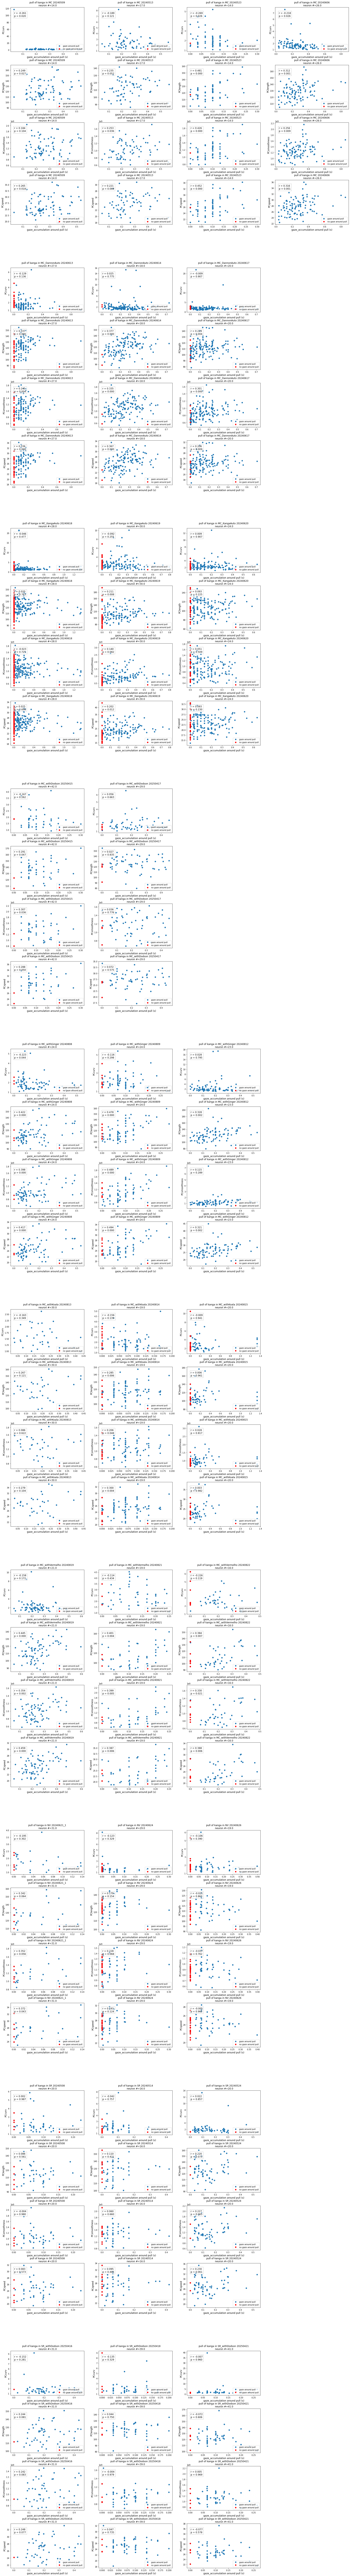

In [359]:
# step 2 for each PCA trace, calculate the length, curvature, and/or tortusity for comparison later
# test hypothesis: 1. for testing if individual trial different was from gaze start time/stop time/gaze duration
    
import statsmodels.formula.api as smf
import statsmodels.api as sm

FRPCAfeatures_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','act_animal','succrate',
                                                                    'bhv_name','bhv_id',
                                                                    'PClength','PCcurv','PCtort','PCspeed','PCsmoothness',
                                                                    'PCspeed_trace','PCcurv_trace',
                                                                    ])
FRPCAfeatures_gazeduration_corr_all_sessions_df = pd.DataFrame(columns=['condition','session','succrate',
                                                                        'act_animal','bhv_name',])

# add three kinds of gaze duration definition (around pull, before pull, after pull)
gaze_duration_type = 'before_pull' # 'around_pull', 'before_pull', 'after_pull'

#
for ianimal_ana in np.arange(0,nanimal_to_ana,1):
    act_animal_ana = act_animals_to_ana[ianimal_ana]
    ind_animal = FRPCA_all_sessions_allevents_sum_df['act_animal']==act_animal_ana
        
    # get the dates
    dates_toplot = np.unique(FRPCA_all_sessions_allevents_sum_df[ind_animal]['session'])
    ndates_toplot = np.shape(dates_toplot)[0]
    
    # figures 
    fig1, axs1 = plt.subplots(nconds_to_ana,ndates_toplot)
    fig1.set_figheight(24*nconds_to_ana)
    fig1.set_figwidth(8*ndates_toplot)
    # Ensure axs1 is always 2D
    axs1 = np.atleast_2d(axs1)
    axs1_flat = axs1.flatten()  # Flatten for easier iteration
    # Track used axes
    used_axes = set()

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_sessions_allevents_sum_df['condition']==cond_ana

        # get the dates
        dates_ana = np.unique(FRPCA_all_sessions_allevents_sum_df[ind_animal & ind_cond]['session'])
        ndates_ana = np.shape(dates_ana)[0]

        for idate_ana in np.arange(0,ndates_ana,1):
            date_ana = dates_ana[idate_ana]
            ind_date = FRPCA_all_sessions_allevents_sum_df['session']==date_ana         

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_sessions_allevents_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                FRPCA_allevents_toana = FRPCA_all_sessions_allevents_sum_df[ind_ana]

                bhv_ids = np.array(FRPCA_allevents_toana['bhv_id'])
                nbhvevents = np.shape(bhv_ids)[0]

                for ibhv_id in np.arange(0,nbhvevents,1):

                    bhv_id = bhv_ids[ibhv_id]
                    ind_bhvid = FRPCA_allevents_toana['bhv_id'] == bhv_id

                    # 
                    # analyze the pull triggered behavioral events
                    if pull_trig_events_tgtname == 'socialgaze_prob':
                        # calculate the gaze start and gaze stop time, and finally gaze duration
                        try:
                            pulltrig_conBhv = np.array(FRPCA_allevents_toana[ind_bhvid][pull_trig_events_tgtname])[0]

                            # Find the point of first increasing and last decrease to estimate gaze start and end
                            #
                            timewins = np.arange(-4,4,1/fps) # make sure it align with the setting in the previous section
                            #
                            # if gaze_duration_type == 'before_pull':
                            #     pulltrig_conBhv[timewins>0] = 0
                            # elif gaze_duration_type == 'after_pull':
                            #     pulltrig_conBhv[timewins<0] = 0                           
                            
                            if 1:
                                first_increase_idx = np.where(np.diff(pulltrig_conBhv) > 0)[0][0] + 1
                                #
                                last_decrease_idx = np.where(np.diff(pulltrig_conBhv) < 0)[0][-1] + 1  # Find last decrease
                                #
                                gazestart_time = timewins[first_increase_idx].copy()
                                gazestop_time = timewins[last_decrease_idx].copy()
                            if 0:
                                # Find peaks
                                peaks, _ = scipy.signal.find_peaks(pulltrig_conBhv)
                                #
                                # Get first and last peak
                                first_peak = peaks[0] 
                                last_peak = peaks[-1]
                                #
                                gazestart_time = timewins[first_peak].copy()
                                gazestop_time = timewins[last_peak].copy()
                            #
                            # change the gazestart and gazestop time based on the gaze duration definition
                            if gaze_duration_type == 'around_pull':
                                gazestart_time = gazestart_time
                                gazestop_time = gazestop_time
                            if gaze_duration_type == 'before_pull':
                                if (gazestart_time > 0):
                                    gazestart_time = np.nan
                                    gazestop_time = np.nan
                                elif (gazestop_time > 0):
                                    gazestop_time = 0
                            if gaze_duration_type == 'after_pull':
                                if (gazestop_time < 0):
                                    gazestart_time = np.nan
                                    gazestop_time = np.nan
                                elif (gazestart_time < 0):
                                    gazestart_time = 0                                                
                            #
                            # if (gazestart_time == timewins[0]) | (gazestart_time == timewins[-1]):
                            #     gazestart_time = np.nan
                            # if (gazestop_time == timewins[0]) | (gazestop_time == timewins[-1]):
                            #     gazestop_time = np.nan
                            if (gazestop_time < gazestart_time):
                                gazestart_time = np.nan
                                gazestop_time = np.nan                           
                        except:
                            gazestart_time = np.nan
                            gazestop_time = np.nan
                            
                        # calculate the gaze accumulation (use auc to estimate)
                        try:
                            timewins = np.arange(-4,4,1/fps) # make sure it align with the setting in the previous section
                            dt = 1 / fps  # sampling interval in seconds
                            #
                            if gaze_duration_type == 'around_pull':
                                auc = np.trapz(pulltrig_conBhv, dx=dt)
                            if gaze_duration_type == 'before_pull':
                                auc = np.trapz(pulltrig_conBhv[timewins<0], dx=dt)
                            if gaze_duration_type == 'after_pull':
                                auc = np.trapz(pulltrig_conBhv[timewins>0], dx=dt)
                            #
                            gaze_accum = auc
                        #
                        except:
                            gaze_accum = np.nan
                                
                            
                    
                    # 
                    # analyze the PCs 
                    FRPCA_ievent_toana = np.array(FRPCA_allevents_toana[ind_bhvid]['PCs'])[0]

                    # smooth the pc trajectory
                    if 0:
                        FRPCA_ievent_toana = np.apply_along_axis(gaussian_filter1d, axis=0, 
                                                                 arr=FRPCA_ievent_toana, sigma=6)

                    # calculate the length, curvature and tortuosity
                    PC_traj = FRPCA_ievent_toana.copy()  # Shape (240, 3)
                    
                    #
                    if gaze_duration_type == 'before_pull':
                        ntimepoints = np.shape(PC_traj)[0]
                        PC_traj = PC_traj[0:int(ntimepoints/2),:]
                    elif gaze_duration_type == 'after_pull':
                        ntimepoints = np.shape(PC_traj)[0]
                        PC_traj = PC_traj[int(ntimepoints/2):,:]

                    # Compute differences between consecutive points
                    diffs = np.diff(PC_traj, axis=0)

                    # Compute segment lengths
                    segment_lengths = np.linalg.norm(diffs, axis=1)
                    total_length = np.sum(segment_lengths)  # Arc length of trajectory

                    # Compute curvature
                    # First derivatives
                    dX_dt = np.gradient(PC_traj[:, 0])
                    dY_dt = np.gradient(PC_traj[:, 1])
                    dZ_dt = np.gradient(PC_traj[:, 2])
                    dV = np.vstack((dX_dt, dY_dt, dZ_dt)).T

                    # Second derivatives
                    d2X_dt2 = np.gradient(dX_dt)
                    d2Y_dt2 = np.gradient(dY_dt)
                    d2Z_dt2 = np.gradient(dZ_dt)
                    d2V = np.vstack((d2X_dt2, d2Y_dt2, d2Z_dt2)).T

                    # Curvature formula: ||dV x d2V|| / ||dV||^3
                    cross_prod = np.cross(dV[:-1], d2V[:-1])  # Compute cross product
                    curvature = np.linalg.norm(cross_prod, axis=1) / (np.linalg.norm(dV[:-1], axis=1) ** 3 + 1e-10)

                    # Compute tortuosity: Total length / Euclidean distance between start and end
                    euclidean_distance = np.linalg.norm(PC_traj[-1] - PC_traj[0])
                    tortuosity = total_length / euclidean_distance if euclidean_distance > 0 else np.nan
                    
                    # Compute speed 
                    dt = 1.0 / fps  # Time between frames
                    # Velocity: first derivative of position
                    velocity = np.gradient(PC_traj, axis=0) / dt
                    # Speed: magnitude of velocity
                    speed = np.linalg.norm(velocity, axis=1)
                    
                    # Compute Smoothness - A simple way to compute trajectory smoothness is to look at the jerk 
                    # — the third derivative of position (how quickly acceleration changes), 
                    # which reflects sudden directional/velocity shifts
                    # Acceleration: second derivative
                    acceleration = np.gradient(velocity, axis=0) / dt
                    # Jerk: third derivative
                    jerk = np.gradient(acceleration, axis=0) / dt
                    # Smoothness metric: integrated squared jerk over time
                    squared_jerk = np.linalg.norm(jerk, axis=1) ** 2
                    smoothness = np.sum(squared_jerk) * dt

                    FRPCAfeatures_all_sessions_allevents_sum_df = FRPCAfeatures_all_sessions_allevents_sum_df.append({
                                                                                'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'session':date_ana,
                                                                                'succrate':np.array(FRPCA_allevents_toana[ind_bhvid]['succrate'])[0],
                                                                                'bhv_id':ibhv_id,
                                                                                'PClength':total_length,
                                                                                'PCcurv':np.nanmean(curvature),
                                                                                'PCtort':tortuosity,
                                                                                'PCspeed':np.nanmean(speed),
                                                                                'PCsmoothness':smoothness,
                                                                                'PCspeed_trace':speed,
                                                                                'PCcurv_trace':curvature,
                                                                                'gazestart_time':gazestart_time,
                                                                                'gazestop_time':gazestop_time,
                                                                                'gaze_accum':gaze_accum,
                                                                                'neuronNumBeforePCA':np.array(FRPCA_allevents_toana[ind_bhvid]['neuronNumBeforePCA'])[0],
                                                                               }, ignore_index=True)
                    
                   
                
                # after pool all the events related data together do some plotting and calculate the correlation
                ind_sess_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == date_ana
                ind_ani_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['act_animal'] == act_animal_ana
                ind_bhv_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['bhv_name'] == bhvname_ana
                ind_cond_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['condition'] == cond_ana
                
                ind_toplot = ind_sess_toplot & ind_ani_toplot & ind_bhv_toplot & ind_cond_toplot
                FRPCAfeatures_toplot = FRPCAfeatures_all_sessions_allevents_sum_df[ind_toplot]
                
                yyy_types = ['PCcurv','PClength','PCsmoothness','PCspeed']
                nytypes = np.shape(yyy_types)[0]
                
                # xxx_type = 'gaze_duration'
                xxx_type = 'gaze_accumulation'
                
                # Use gridspec to divide axs1[icond_ana, idate_ana] into nytypes rows
                gs = gridspec.GridSpecFromSubplotSpec(nytypes, 1, subplot_spec=axs1[icond_ana, idate_ana], hspace=0.3)

                for iytype in np.arange(0,nytypes,1):
                    
                    ax = fig1.add_subplot(gs[iytype])  # Create subplots within the existing grid cell
                    used_axes.add(ax)  # Mark this axis as used
                    
                    if xxx_type == 'gaze_duration':
                        xxx = FRPCAfeatures_toplot['gazestop_time'] - FRPCAfeatures_toplot['gazestart_time']
                    elif xxx_type == 'gaze_accumulation':
                        xxx = FRPCAfeatures_toplot['gaze_accum']
                    
                    yyy_type = yyy_types[iytype]
                    yyy = FRPCAfeatures_toplot[yyy_type]
                    
                    ind_nan = np.isnan(xxx) | np.isnan(yyy)
                    xxx = xxx[~ind_nan]
                    yyy = yyy[~ind_nan]

                    # Compute correlation
                    if len(xxx) > 1:
                        r, p = st.pearsonr(xxx, yyy)
                    else:
                        r, p = np.nan, np.nan

                    ax.plot(xxx, yyy, 'o',label='gaze around pull')
                    ax.set_title(bhvname_ana+' of '+act_animal_ana+' in '+
                                 cond_ana+' '+date_ana+'\n neuron #='+
                                 str(FRPCAfeatures_toplot['neuronNumBeforePCA'].iloc[0]),fontsize=12)
                    ax.set_ylabel(yyy_type,fontsize=12)

                    # Add correlation text on the figure
                    ax.text(0.05, 0.9, f"r = {r:.3f}\np = {p:.3f}", transform=ax.transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

                    #
                    # plot the one without any gaze as a comparison
                    xxx = FRPCAfeatures_toplot['gazestop_time'] - FRPCAfeatures_toplot['gazestart_time']
                    
                    yyy_type = yyy_types[iytype]
                    yyy = FRPCAfeatures_toplot[yyy_type]
                    
                    ind_nan = (np.isnan(xxx)) & (~np.isnan(yyy))
                    yyy = yyy[ind_nan]
                    xxx = np.zeros(np.shape(yyy))
                    
                    ax.plot(xxx, yyy, 'ro',label='no gaze around pull')
                    
                    ax.set_xlabel(xxx_type+' around pull (s)',fontsize=12)  # Set xlabel only for the last subplot in the stack
                    ax.legend(loc='lower right')
            
                    # 
                    FRPCAfeatures_gazeduration_corr_all_sessions_df = FRPCAfeatures_gazeduration_corr_all_sessions_df.append({
                                                                                'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'session':date_ana,
                                                                                'succrate':np.array(FRPCA_allevents_toana[ind_bhvid]['succrate'])[0],
                                                                                'corr_'+yyy_type+'_vs_'+xxx_type:r,
                                                                                'pcorr_'+yyy_type+'_vs_'+xxx_type:p,
                                                                                'gazeduration_definition':gaze_duration_type,
                                                                               }, ignore_index=True)
                                                               
                                                               
    # fig1.tight_layout()
    
    #  Hide unused subplots
    for ax in axs1_flat:
        if ax not in used_axes:  # If an axis wasn't used, hide it
            ax.set_visible(False)

    
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_Pullfocused_continuousBhv/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevents_aligned_PCspace_trajectory_features_and_continuousBhv_'+
                     pull_trig_events_tgtname+'_'+xxx_type+'_'+gaze_duration_type+savefile_sufix+'.pdf')
        


correlation between:corr_PClength_vs_gaze_accumulation succrate
condition
MC                 0.616162
MC_DannonAuto     -0.564934
MC_KangaAuto       0.312156
MC_withDodson      1.000000
MC_withGinger      0.992034
MC_withKoala      -0.515194
MC_withVermelho   -0.627050
NV                -0.942594
SR                 0.636488
SR_withDodson           NaN
dtype: float64


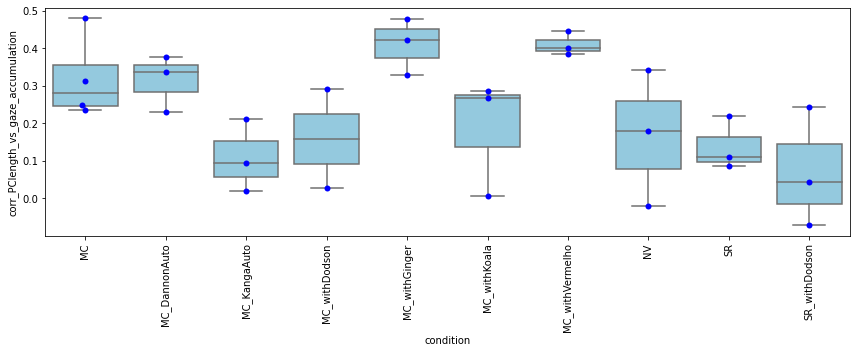

In [360]:
# show all the session-by-session correlation between PC trajectory features and gaze duration 
if 1:    
    import itertools
    
    # corr_type = 'corr_PClength_vs_gaze_duration'
    corr_type = 'corr_PClength_vs_gaze_accumulation'

    fig2, axs2 = plt.subplots(1, 1)
    fig2.set_figheight(5)
    fig2.set_figwidth(12)

    # Define a consistent color
    box_color = 'skyblue'

    # Plot boxplot and swarmplot
    seaborn.boxplot(ax=axs2, data=FRPCAfeatures_gazeduration_corr_all_sessions_df,
                x='condition', y=corr_type,
                color=box_color)

    seaborn.swarmplot(ax=axs2, data=FRPCAfeatures_gazeduration_corr_all_sessions_df,
                  x='condition', y=corr_type,
                  color='b', size=6)

    # Rotate x-axis ticks
    axs2.set_xticklabels(axs2.get_xticklabels(), rotation=90)

    # Significance from 0 (Wilcoxon signed-rank)
    conditions = FRPCAfeatures_gazeduration_corr_all_sessions_df['condition'].unique()
    y_max = FRPCAfeatures_gazeduration_corr_all_sessions_df[corr_type].max()
    y_min = FRPCAfeatures_gazeduration_corr_all_sessions_df[corr_type].min()

    y_offset = (y_max - y_min) * 0.05  # vertical spacing for significance bars

    for i, cond in enumerate(conditions):
        data = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition'] == cond][corr_type].dropna()
        if len(data) > 0 and np.any(data != 0):  # Wilcoxon requires non-zero variation
            try:
                stat, p = st.wilcoxon(data)
                if p < 0.01:
                    axs2.text(i, data.max() + y_offset, '*', ha='center', va='bottom', fontsize=16, color='black')
            except ValueError:
                pass  # skip if data not suitable for Wilcoxon

    # Pairwise comparisons (Mann–Whitney U)
    pairs = list(itertools.combinations(range(len(conditions)), 2))
    for j, (i1, i2) in enumerate(pairs):
        cond1 = conditions[i1]
        cond2 = conditions[i2]
        data1 = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition'] == cond1][corr_type].dropna()
        data2 = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition'] == cond2][corr_type].dropna()

        if len(data1) > 0 and len(data2) > 0:
            stat, p = st.mannwhitneyu(data1, data2, alternative='two-sided')
            if p < 0.01:
                y = max(data1.max(), data2.max()) + y_offset * (j + 2)
                axs2.plot([i1, i2], [y, y], lw=1.5, c='black')
                axs2.text((i1 + i2) / 2, y + y_offset * 0.2, '*', ha='center', va='bottom', fontsize=16)
     
    fig2.tight_layout()

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_Pullfocused_continuousBhv/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig2.savefig(figsavefolder+'bhvevents_aligned_PCspace_trajectory_features_and_continuousBhv_'+
                     pull_trig_events_tgtname+'_'+gaze_duration_type+'_'+corr_type+savefile_sufix+'.pdf')
        

    # to see if there's correlation between correlation coefficient of PC features vs gaze duration, and succ rate 
    # Drop rows where either column is NaN
    subset_df = FRPCAfeatures_gazeduration_corr_all_sessions_df[['condition', 'succrate', corr_type]].dropna()

    # Group by condition and calculate Pearson correlation
    grouped_corrs = (
        subset_df
        .groupby('condition')
        .apply(lambda g: g['succrate'].corr(g[corr_type]))
    )

    # Display the result
    print('correlation between:'+corr_type+' succrate')
    print(grouped_corrs)
        

In [361]:
# show the single trial trajectories of an example session - compared the nogaze_pull and gaze_pull
if 0:
    # Create a 3D figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # animal_exmaple = 'dodson'
    # session_example = '20240603_MC'
    animal_exmaple = 'kanga'
    session_example = '202408123","20250403_SR'

    ind_example = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == session_example
    FRPCAfeatures_example = FRPCAfeatures_all_sessions_allevents_sum_df[ind_example]
    #
    ind_example = FRPCA_all_sessions_allevents_sum_df['session']==session_example
    FRPCA_example = FRPCA_all_sessions_allevents_sum_df[ind_example]

    # plot the nogazearound_pull tracjectory
    ind_nogaze = (np.isnan(FRPCAfeatures_example['gazestart_time'])) & (np.isnan(FRPCAfeatures_example['gazestop_time']))
    nogaze_pullIDs = np.array(FRPCAfeatures_example[ind_nogaze]['bhv_id'])
    #
    ind_nogazepullIDs = np.isin(FRPCA_example['bhv_id'],nogaze_pullIDs)
    FRPCA_nogazepulls = np.array(FRPCA_example[ind_nogazepullIDs]['PCs'])
    n_nogazepulls = np.shape(FRPCA_nogazepulls)[0]
    #
    for ii in np.arange(0,n_nogazepulls,1):
    # for ii in np.arange(0,1,1):
        xxx = gaussian_filter1d(FRPCA_nogazepulls[ii][:,0],6)
        yyy = gaussian_filter1d(FRPCA_nogazepulls[ii][:,1],6)
        zzz = gaussian_filter1d(FRPCA_nogazepulls[ii][:,2],6)

        if ii == 0:
            ax.plot3D(xxx, yyy, zzz, color='r', linewidth=2, label='no gaze around pull FR PC trajectory')
        else:
            ax.plot3D(xxx, yyy, zzz, color='r', linewidth=2)

    # plot the gazearound pull trajectory
    FRPCA_gazepulls = np.array(FRPCA_example[~ind_nogazepullIDs]['PCs'])
    n_gazepulls = np.shape(FRPCA_gazepulls)[0]
    ind_gazepulls_toplot = np.random.choice(np.arange(0, n_gazepulls, 1), size=n_nogazepulls, replace=False)
    # 
    for ii in ind_gazepulls_toplot:
        xxx = gaussian_filter1d(FRPCA_gazepulls[ii][:,0],6)
        yyy = gaussian_filter1d(FRPCA_gazepulls[ii][:,1],6)
        zzz = gaussian_filter1d(FRPCA_gazepulls[ii][:,2],6)

        if ii == ind_gazepulls_toplot[0]:
            ax.plot3D(xxx, yyy, zzz, color='b', linewidth=2, label='gaze around pull FR PC trajectory')
        else:
            ax.plot3D(xxx, yyy, zzz, color='b', linewidth=2)

    ax.legend()

In [362]:
# show the single trial trajectories of an example session - compared the gaze_pull separating three quantile based on the gaze duration
if 0:
    # Create a 3D figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # animal_exmaple = 'dodson'
    # session_example = '20250409'
    animal_exmaple = 'dodson'
    session_example = '20250415'
    
    # animal_exmaple = 'kanga'
    # session_example = '20240809'
    # animal_exmaple = 'kanga'
    # session_example = '20240606'
    # animal_exmaple = 'kanga'
    # session_example = '20250415'


    ind_example = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == session_example
    FRPCAfeatures_example = FRPCAfeatures_all_sessions_allevents_sum_df[ind_example]
    #
    ind_example = FRPCA_all_sessions_allevents_sum_df['session']==session_example
    FRPCA_example = FRPCA_all_sessions_allevents_sum_df[ind_example]
    
    #
    gaze_durations = FRPCAfeatures_example['gazestop_time'] - FRPCAfeatures_example['gazestart_time']
    # gaze_durations = FRPCAfeatures_example['gaze_accum']
    gaze_durations = np.array(gaze_durations)
    #
    # Compute tertile (33rd and 67th percentiles), ignoring NaNs
    q1, q2 = np.nanquantile(gaze_durations, [1/3, 2/3])
    #
    # Separate data into three groups
    ind_low = gaze_durations <= q1
    ind_mid = (gaze_durations > q1) & (gaze_durations <= q2)
    ind_high = gaze_durations > q2
    
    for ii in np.arange(0,3,1):
        if ii == 0:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_low]['PCs'], axis=0),axis=0)
            traj_clr = 'b'
            traj_lab = 'low gaze duration ' + str(np.sum(ind_low))+' trials'
        elif ii == 1:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_mid]['PCs'], axis=0),axis=0)
            traj_clr = 'r'
            traj_lab = 'mid gaze duration ' + str(np.sum(ind_mid))+' trials'
        elif ii == 2:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_high]['PCs'], axis=0),axis=0)
            traj_clr = 'y'
            traj_lab = 'high gaze duration ' + str(np.sum(ind_high))+' trials'
           
        ntimepoints = np.shape(meanPCA_traj)[0]
        
        xxx = gaussian_filter1d(meanPCA_traj[:,0],6)
        yyy = gaussian_filter1d(meanPCA_traj[:,1],6)
        zzz = gaussian_filter1d(meanPCA_traj[:,2],6)
        if gaze_duration_type == 'before_pull':
            xxx = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),0],3)
            yyy = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),1],3)
            zzz = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),2],3)   
        elif gaze_duration_type == 'after_pull':
            xxx = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,0],3)
            yyy = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,1],3)
            zzz = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,2],3)   
            
        ax.plot3D(xxx, yyy, zzz, color=traj_clr, linewidth=2, label=traj_lab)
        ax.plot3D(xxx[0], yyy[0], zzz[0], color=traj_clr, marker ='o',markersize = 12)
        ax.plot3D(xxx[-1], yyy[-1], zzz[-1], color=traj_clr, marker ='s',markersize = 12)

    
    ax.legend()
    
    

In [363]:
# show the single trial  an example session - compared the gaze_pull separating three quantile based on the gaze duration
# average and show the speed or curvature trace of each quantile
if 0:
    # Create a figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    trace_toplot = 'PCspeed_trace'
    
    animal_exmaple = 'dodson'
    session_example = '20250415'
    # animal_exmaple = 'dodson'
    # session_example = '20240612'
    
    # animal_exmaple = 'kanga'
    # session_example = '20240809'
    # animal_exmaple = 'kanga'
    # session_example = '20240523'
    # animal_exmaple = 'kanga'
    # session_example = '20250415'


    ind_example = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == session_example
    FRPCAfeatures_example = FRPCAfeatures_all_sessions_allevents_sum_df[ind_example]
    #
    ind_example = FRPCA_all_sessions_allevents_sum_df['session']==session_example
    FRPCA_example = FRPCA_all_sessions_allevents_sum_df[ind_example]

    gaze_durations = FRPCAfeatures_example['gazestop_time'] - FRPCAfeatures_example['gazestart_time']
    gaze_durations = np.array(gaze_durations)
    #
    # Compute tertile (33rd and 67th percentiles), ignoring NaNs
    q1, q2 = np.nanquantile(gaze_durations, [1/3, 2/3])
    #
    # Separate data into three groups
    ind_low = gaze_durations <= q1
    ind_mid = (gaze_durations > q1) & (gaze_durations <= q2)
    ind_high = gaze_durations > q2
    
    for ii in np.arange(0,3,1):
        if ii == 0:
            meanPCA_traj = np.nanmean(np.stack(FRPCAfeatures_example[ind_low][trace_toplot], axis=0),axis=0)
            traj_clr = 'b'
            traj_lab = 'low gaze duration ' + str(np.sum(ind_low))+' trials'
        elif ii == 1:
            meanPCA_traj = np.nanmean(np.stack(FRPCAfeatures_example[ind_mid][trace_toplot], axis=0),axis=0)
            traj_clr = 'r'
            traj_lab = 'mid gaze duration' + str(np.sum(ind_mid))+' trials'
        elif ii == 2:
            meanPCA_traj = np.nanmean(np.stack(FRPCAfeatures_example[ind_high][trace_toplot], axis=0),axis=0)
            traj_clr = 'y'
            traj_lab = 'high gaze duration' + str(np.sum(ind_high))+' trials'
           
        ntimepoints = np.shape(meanPCA_traj)[0]
        
        if gaze_duration_type == 'around_pull':
            xtimes = np.arange(-4,4,1/fps)
            xxx = gaussian_filter1d(meanPCA_traj,6)
        else:
            xtimes = np.arange(-4,0,1/fps)
            xxx = gaussian_filter1d(meanPCA_traj,6)
            
        ax.plot(xtimes, xxx, color=traj_clr, linewidth=2, label=traj_lab)
        ax.plot(xtimes[0], xxx[0], color=traj_clr, marker ='o',markersize = 12)
        ax.plot(xtimes[-1], xxx[-1], color=traj_clr, marker ='s',markersize = 12)
        
        ax.set_xlabel('time/s')
        ax.set_ylabel('PC trajectory speed')
    
    ax.legend()
    
    

#### sanity check plot, indibidual neurons' pull aligned FR and gaze related measures

In [364]:
# this one needs to be run after the previous code becuase it need the definition of the 
# gaze_duration or gaze_accumulation from the previous code

if 0:
    
    # load the data 
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond_FRPCA = FRPCAfeatures_all_sessions_allevents_sum_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
            ind_animal_FRPCA = FRPCAfeatures_all_sessions_allevents_sum_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana
                ind_date_FRPCA = FRPCAfeatures_all_sessions_allevents_sum_df['session']==date_ana

                # get the neurons 
                neurons_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                # get the gaze related features
                features_ana = FRPCAfeatures_all_sessions_allevents_sum_df[ind_animal_FRPCA&ind_cond_FRPCA&ind_date_FRPCA]
                
                # Determine subplot grid (5 columns, dynamic rows)
                ncols = 5
                nrows = int(np.ceil(nneurons / ncols))

                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6), constrained_layout=True)
                axes = np.ravel(axes)  # Flatten for easy indexing
                
                # === New heatmap plot per date for neuron correlation over time ===
                fig_corr, ax_corr = plt.subplots(figsize=(10, max(6, 0.3 * nneurons)))

                # Store r_trace and p_trace for each neuron
                r_traces_all_neurons = []
                p_traces_all_neurons = []

                for ineuron in np.arange(0,nneurons,1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron

                    ax = axes[ineuron]  # Get the subplot for this neuron

                    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
                            
                        #
                        # load and plot bhv event ('gazestart'/'gazestop') aligned FR
                        FRs_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt['FR_allevents'])[0]

                        nevents = np.shape(FRs_allevents_ineuron)[1]

                        FRsmoothed_allevents_ineuron = gaussian_filter1d(FRs_allevents_ineuron, sigma=6, axis=0)

                        # separating FR based on the gaze related features (three quantiles)
                        # xxx_type = 'gaze_duration'
                        xxx_type = 'gaze_accumulation'
                        if xxx_type == 'gaze_duration':
                            gaze_durs_ineurons = np.array(features_ana['gazestop_time']-\
                                                          features_ana['gazestart_time'])
                        elif xxx_type == 'gaze_accumulation':
                            gaze_durs_ineurons = np.array(features_ana['gaze_accum'])
                        
                        ngazes = np.shape(gaze_durs_ineurons)[0]
                        
                        print(date_ana+' pull aligned FR # = '+str(nevents)+'; pull aligned gaze # = '+str(ngazes))
                        
                        # Compute quantiles
                        q1, q2 = np.nanpercentile(gaze_durs_ineurons, [33, 66])

                        # Get indices for each quantile group
                        short_idx = np.where(gaze_durs_ineurons <= q1)[0]
                        mid_idx   = np.where((gaze_durs_ineurons > q1) & (gaze_durs_ineurons <= q2))[0]
                        long_idx  = np.where(gaze_durs_ineurons > q2)[0]

                        quantile_groups = {
                            'Short': short_idx,
                            'Medium': mid_idx,
                            'Long': long_idx
                        }

                        quantile_colors = {
                            'Short': '#1f77b4',   # blue
                            'Medium': '#ff7f0e',  # orange
                            'Long': '#2ca02c'     # green
                        }

                        time_trace = np.arange(-4,4,1/fps)
                        
                        # Plot FRs by quantile
                        for label, idx in quantile_groups.items():
                            if len(idx) == 0:
                                continue

                            mean_trace = np.nanmean(FRsmoothed_allevents_ineuron[:, idx], axis=1)
                            sem_trace = np.nanstd(FRsmoothed_allevents_ineuron[:, idx], axis=1) / np.sqrt(len(idx))

                            ax.plot(time_trace, mean_trace, label=f"{bhvname_ana} - {label} (n={len(idx)})",
                                    color=quantile_colors[label])
                            ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace,
                                            color=quantile_colors[label], alpha=0.3)
                        
                        
                        # plot the correlation coefficient
                        # === Compute time-varying correlation between FR and gaze duration ===
                        n_timepoints = FRsmoothed_allevents_ineuron.shape[0]
                        r_trace = np.full(n_timepoints, np.nan)
                        p_trace = np.full(n_timepoints, np.nan)

                        if xxx_type == 'gaze_duration':
                            gaze_durs = np.array(features_ana['gazestop_time']-\
                                                          features_ana['gazestart_time'])
                        elif xxx_type == 'gaze_accumulation':
                            gaze_durs = np.array(features_ana['gaze_accum'])
                            
                        valid_gaze_mask = ~np.isnan(gaze_durs)

                        for t in range(n_timepoints):
                            fr_t = FRsmoothed_allevents_ineuron[t, :]
                            valid_fr_mask = ~np.isnan(fr_t)
                            valid_mask = valid_fr_mask & valid_gaze_mask

                            if np.sum(valid_mask) > 2:
                                r, p = st.pearsonr(fr_t[valid_mask], gaze_durs[valid_mask])
                                r_trace[t] = r
                                p_trace[t] = p
                                
                        r_traces_all_neurons.append(r_trace)
                        p_traces_all_neurons.append(p_trace)

                        # === Plot on right Y-axis ===
                        ax2 = ax.twinx()
                        ax2.plot(time_trace, r_trace, color='black', linestyle='-', linewidth=2, label='Gaze-FR Corr')
                        ax2.set_ylabel("Corr(GazeDur, FR)", color='black')
                        ax2.tick_params(axis='y', labelcolor='black')
                        ax2.set_ylim([-1, 1])
                        ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

                        # Plot significant time points (p < 0.01) as red dots
                        sig_mask = (p_trace < 0.01) & (~np.isnan(p_trace)) & (~np.isnan(r_trace))
                        ax2.plot(time_trace[sig_mask], r_trace[sig_mask], 'ro', markersize=4, label='p < 0.01')
                        
                    ax.set_title(f"Neuron {clusterID_ineuron}")
                    ax.set_xlabel("Time (s)")
                    ax.set_ylabel("Firing Rate (a.u.)")
                    # ax.set_title(act_animal_ana+' '+cond_ana+' '+date_ana+' cell#'+clusterID_ineuron)
                    ax.legend()
                    #
                    ax2.set_ylabel("Corr(GazeDur, FR)", color='black')
                    ax2.tick_params(axis='y', labelcolor='black')
                    ax2.set_ylim([-1, 1])

                # Hide empty subplots if nneurons < total grid size
                for i in range(nneurons, len(axes)):
                    fig.delaxes(axes[i])

                # Figure title
                fig.suptitle(f"{act_animal_ana} {cond_ana} {date_ana}", fontsize=14)                
                
                
                # Convert to numpy array for heatmap
                r_traces_all_neurons = np.array(r_traces_all_neurons)

                # === Sort r_traces by the time of their first peak ===
                peak_times = []
                for trace in r_traces_all_neurons:
                    if np.all(np.isnan(trace)):
                        peak_times.append(np.inf)
                    else:
                        peak_idx = np.nanargmax(trace)
                        peak_times.append(time_trace[peak_idx])

                # Get sorting indices based on peak times
                sorted_indices = np.argsort(peak_times)
                r_traces_sorted = r_traces_all_neurons[sorted_indices, :]

                # Plot heatmap of r values
                im = ax_corr.imshow(r_traces_sorted, aspect='auto', cmap='gray_r', interpolation='none',
                                    extent=[time_trace[0], time_trace[-1], 0, nneurons],
                                    vmin=-0.7, vmax=0.7)

                # Overlay significance as red dots
                for i, idx in enumerate(sorted_indices):
                    sig_times = np.where(p_traces_all_neurons[idx] < 0.01)[0]
                    for t in sig_times:
                        ax_corr.plot(time_trace[t], i + 0.5, 'r.', markersize=3)  # i+0.5 to center in the row

                # Add vertical dashed line at time = 0
                ax_corr.axvline(x=0, color='black', linestyle='--', linewidth=1)

                # Add vertical dashed line at time zero
                ax_corr.axvline(x=0, linestyle='--', color='gray', linewidth=1)

                ax_corr.set_xlabel("Time (s)")
                ax_corr.set_ylabel("Neuron (sorted by peak time)")
                ax_corr.set_title(f"Neuron-wise Corr(Gaze, FR) Heatmap (Sorted): {act_animal_ana} {cond_ana} {date_ana}")
                cbar = fig_corr.colorbar(im, ax=ax_corr)
                cbar.set_label('Pearson r')
                
                # plt.show()
                
                savefig = 1
                if savefig:
                    figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_Pullfocused_continuousBhv/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+date_ana+'/'

                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)

                    fig.savefig(figsavefolder+'individualneurons_FR_in_quantiles_'+
                                 pull_trig_events_tgtname+'_'+gaze_duration_type+'_'+xxx_type+savefile_sufix+'.pdf')

                    fig_corr.savefig(figsavefolder + 'neuron_corr_heatmap_' + 
                                     pull_trig_events_tgtname+'_'+gaze_duration_type+'_'+xxx_type+savefile_sufix+'.pdf')

                # Close the figures to avoid memory issues
                plt.close(fig)
                plt.close(fig_corr)

## analysis with 'trial pooling' across sessions from the same condition
### pool sessions for each task conditions together and then run PCA
#### pool sessions based on quantiles of gaze-accumulation or gaze-length variables (e.g. 5 quantiles)

In [365]:
# only analyze a subset of conditions
# act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
act_animals_to_ana = ['kanga']
# act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
bhv_names_to_ana = ['pull']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
# # the following analysis can only do one conditions 
# # multiple condition will be considered into one conditions for quantile and FR averaging analysis
# conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['SR']
###
# For Kanga
conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVermelho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV'] # NV
###
# For Dodson
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL

nconds_to_ana = np.shape(conditions_to_ana)[0]

doOnlySigniNeurons = 1 # define the significant neurons using the previous code


In [366]:
import numpy as np
import pandas as pd
import scipy.signal

if 1:
    # load and prepare the data
    bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.DataFrame(columns=['condition', 'session', 'act_animal',
                                                                                 'bhv_name', 'bhv_id', 'FR_ievent',
                                                                                 'clusterID', 'channelID',
                                                                                 'gaze_accum_ievent', 'gaze_start_ievent',
                                                                                 'gaze_stop_ievent',
                                                                                 ])
    #
    bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = pd.DataFrame()

    # step 1 for the bhvevents_aligned_FR_allevents_all_dates_df, get and gaze-related variables and calculate features

    # it's better to match this variable with the previous one
    # add three kinds of gaze duration definition (around pull, before pull, after pull)
    gaze_duration_type = 'before_pull'  # 'around_pull', 'before_pull', 'after_pull'
    xxx_type = 'gaze_accum'  # 'gaze_dur' or 'gaze_accum'

    # special here, number of quantile to use for pooling across different days
    num_quantiles = 4

    #
    for icond_ana in np.arange(0, nconds_to_ana, 1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition'] == cond_ana

        for ianimal_ana in np.arange(0, nanimal_to_ana, 1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal'] == act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0, ndates_ana, 1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates'] == date_ana

                # get the neurons
                neurons_ana = np.unique(
                    bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                for ineuron in np.arange(0, nneurons, 1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID'] == clusterID_ineuron

                    for ibhvname_ana in np.arange(0, nbhvnames_to_ana, 1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'] == bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[
                            ind_ana].copy()  # Use .copy() to avoid SettingWithCopyWarning

                        if not bhvevents_aligned_FR_allevents_tgt.empty:
                            channelID = bhvevents_aligned_FR_allevents_tgt['channelID'].iloc[0]

                            #
                            # load and plot bhv event ('pull') aligned FR
                            FRs_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt['FR_allevents'].iloc[0])
                            nevents_FR = np.shape(FRs_allevents_ineuron)[1]

                            #
                            # load and plot the pull aligned continuous bhv variables
                            conBhv_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname].iloc[0])
                            conBhv_allevents_ineuron = np.array(conBhv_allevents_ineuron)
                            conBhv_allevents_ineuron = conBhv_allevents_ineuron.transpose()
                            #
                            nevents_bhv = np.shape(conBhv_allevents_ineuron)[1]
                            # if the pull aligned FR and bhv have different number
                            if not nevents_FR == nevents_bhv:
                                # print(date_ana+' mismatched number')
                                if nevents_FR < nevents_bhv:
                                    conBhv_allevents_ineuron = conBhv_allevents_ineuron[:, 0:nevents_FR]
                                else:
                                    FRs_allevents_ineuron = FRs_allevents_ineuron[:, 0:nevents_bhv]

                            #
                            nevents = np.min([nevents_FR, nevents_bhv])

                            # get each bhv events
                            for bhv_id in np.arange(0, nevents, 1):
                                FRs_ievent_ineuron = FRs_allevents_ineuron[:, bhv_id]
                                conBhv_ievent_ineuron = conBhv_allevents_ineuron[:, bhv_id]

                                #
                                # analyze the pull triggered behavioral events
                                if pull_trig_events_tgtname == 'socialgaze_prob':
                                    # calculate the gaze start and gaze stop time, and finally gaze duration
                                    try:
                                        timewins = np.arange(-4, 4, 1 / fps)  # make sure it align with the setting in the previous section

                                        if 1:
                                            first_increase_idx = np.where(
                                                np.diff(conBhv_ievent_ineuron) > 0)[0][0] + 1
                                            #
                                            last_decrease_idx = np.where(
                                                np.diff(conBhv_ievent_ineuron) < 0)[0][-1] + 1  # Find last decrease
                                            #
                                            gazestart_time = timewins[first_increase_idx].copy()
                                            gazestop_time = timewins[last_decrease_idx].copy()
                                        if 0:
                                            # Find peaks
                                            peaks, _ = scipy.signal.find_peaks(conBhv_ievent_ineuron)
                                            #
                                            # Get first and last peak
                                            first_peak = peaks[0]
                                            last_peak = peaks[-1]
                                            #
                                            gazestart_time = timewins[first_peak].copy()
                                            gazestop_time = timewins[last_peak].copy()
                                        #
                                        # change the gazestart and gazestop time based on the gaze duration definition
                                        if gaze_duration_type == 'around_pull':
                                            gazestart_time = gazestart_time
                                            gazestop_time = gazestop_time
                                        if gaze_duration_type == 'before_pull':
                                            if (gazestart_time > 0):
                                                gazestart_time = np.nan
                                                gazestop_time = np.nan
                                            elif (gazestop_time > 0):
                                                gazestop_time = 0
                                        if gaze_duration_type == 'after_pull':
                                            if (gazestop_time < 0):
                                                gazestart_time = np.nan
                                                gazestop_time = np.nan
                                            elif (gazestart_time < 0):
                                                gazestart_time = 0

                                        #
                                        if (gazestop_time < gazestart_time):
                                            gazestart_time = np.nan
                                            gazestop_time = np.nan
                                    except:
                                        gazestart_time = np.nan
                                        gazestop_time = np.nan

                                    # calculate the gaze accumulation (use auc to estimate)
                                    try:
                                        timewins = np.arange(-4, 4, 1 / fps)  # make sure it align with the setting in the previous section
                                        dt = 1 / fps  # sampling interval in seconds
                                        #
                                        if gaze_duration_type == 'around_pull':
                                            auc = np.trapz(conBhv_ievent_ineuron, dx=dt)
                                        if gaze_duration_type == 'before_pull':
                                            auc = np.trapz(conBhv_ievent_ineuron[timewins < 0], dx=dt)
                                        if gaze_duration_type == 'after_pull':
                                            auc = np.trapz(conBhv_ievent_ineuron[timewins > 0], dx=dt)
                                        #
                                        gaze_accum = auc
                                    #
                                    except:
                                        gaze_accum = np.nan

                                bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.concat(
                                    [bhvevents_aligned_FR_and_eventFeatures_all_dates_df, pd.DataFrame({
                                        'condition': [cond_ana],
                                        'act_animal': [act_animal_ana],
                                        'bhv_name': [bhvname_ana],
                                        'session': [date_ana],
                                        'bhv_id': [bhv_id],
                                        'clusterID': [clusterID_ineuron],
                                        'channelID': [channelID],
                                        'gaze_accum_ievent': [gaze_accum],
                                        'gaze_start_ievent': [gazestart_time],
                                        'gaze_stop_ievent': [gazestop_time],
                                        'FR_ievent': [FRs_ievent_ineuron]
                                    })], ignore_index=True)

    # add the quantile information using the all sessions' data
    # consider each date separately

    # Create a list to store the DataFrames for each date
    all_dates_dfs = []

    # Get unique dates
    unique_dates = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'].unique()

    for date_ana in unique_dates:
        date_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
            bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'] == date_ana].copy()

        if xxx_type == 'gaze_accum':
            quantile_tgt = date_df['gaze_accum_ievent'].dropna()  # Handle potential NaNs
            n_unique = len(quantile_tgt.unique())
            n_bins = min(num_quantiles, n_unique - 1)  # Calculate the maximum possible bins
            if n_bins > 1:  # Only proceed if we can make at least 2 bins
                try:
                    quantile_bins = np.nanquantile(quantile_tgt, np.linspace(0, 1, num_quantiles + 1))
                    date_df['gaze_accum_quantile'] = pd.cut(
                        date_df['gaze_accum_ievent'],
                        bins=quantile_bins,
                        labels=False,
                        include_lowest=True,
                        duplicates='drop'  # Drop duplicate bin edges
                    )
                    quantile_col = 'gaze_accum_quantile'
                    title_prefix = 'Gaze Accumulation'
                except ValueError as e:
                    print(f"Warning: Error calculating quantiles on date {date_ana}: {e}")
                    date_df['gaze_accum_quantile'] = np.nan
                    quantile_col = 'gaze_accum_quantile'
                    title_prefix = 'Gaze Accumulation'
            else:
                date_df['gaze_accum_quantile'] = np.nan
                quantile_col = 'gaze_accum_quantile'
                title_prefix = 'Gaze Accumulation'
                print(f"Warning: Not enough distinct data for quantiles on date {date_ana}")

        #
        elif xxx_type == 'gaze_dur':
            date_df['gaze_duration_ievent'] = \
                date_df['gaze_stop_ievent'] - \
                date_df['gaze_start_ievent']
            quantile_tgt = date_df['gaze_duration_ievent'].dropna()  # Handle potential NaNs
            n_unique = len(quantile_tgt.unique())
            n_bins = min(num_quantiles, n_unique - 1)  # Calculate the maximum possible bins
            if n_bins > 1:  # Only proceed if we can make at least 2 bins
                try:
                    quantile_bins = np.nanquantile(quantile_tgt, np.linspace(0, 1, num_quantiles + 1))
                    date_df['gaze_duration_quantile'] = pd.cut(
                        date_df['gaze_duration_ievent'],
                        bins=quantile_bins,
                        labels=False,
                        include_lowest=True,
                        duplicates='drop'  # Drop duplicate bin edges
                    )
                    quantile_col = 'gaze_duration_quantile'
                    title_prefix = 'Gaze Duration'
                except ValueError as e:
                    print(f"Warning: Error calculating quantiles on date {date_ana}: {e}")
                    date_df['gaze_duration_quantile'] = np.nan
                    quantile_col = 'gaze_duration_quantile'
                    title_prefix = 'Gaze Duration'
            else:
                date_df['gaze_duration_quantile'] = np.nan
                quantile_col = 'gaze_duration_quantile'
                title_prefix = 'Gaze Duration'
                print(f"Warning: Not enough distinct data for quantiles on date {date_ana}")

        all_dates_dfs.append(date_df)

    # Concatenate the DataFrames back together
    bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.concat(all_dates_dfs, ignore_index=True)

    # average for each neuron the firing rate of each quantile
    if 'quantile_col' in locals():
        # Iterate through unique (clusterID, session) pairs
        for (cluster_id, session_id) in bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
            ['clusterID', 'session']].drop_duplicates().itertuples(index=False):
            neuron_session_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
                (bhvevents_aligned_FR_and_eventFeatures_all_dates_df['clusterID'] == cluster_id) &
                (bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'] == session_id)
            ].copy()

            for q_val in neuron_session_df[quantile_col].dropna().unique():
                quantile_df = neuron_session_df[neuron_session_df[quantile_col] == q_val]
                if not quantile_df.empty:
                    all_fr_traces = np.vstack(quantile_df['FR_ievent'].tolist())
                    mean_fr_trace = np.nanmean(all_fr_traces, axis=0)

                    # Get representative metadata
                    condition = quantile_df['condition'].iloc[0]
                    act_animal = quantile_df['act_animal'].iloc[0]
                    bhv_name = quantile_df['bhv_name'].iloc[0]
                    channelID = quantile_df['channelID'].iloc[0]

                    new_row = {
                        'condition': condition,
                        'session': session_id,
                        'act_animal': act_animal,
                        'bhv_name': bhv_name,
                        'clusterID': cluster_id,
                        'channelID': channelID,
                        quantile_col: int(q_val),
                        'mean_FR_trace': mean_fr_trace
                    }
                    bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = pd.concat(
                        [bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df,
                         pd.DataFrame([new_row])],
                        ignore_index=True
                    )

In [367]:
# only consider the significant neurons based on the previous analysis
if 1:
    if doOnlySigniNeurons:
        
        #
        # Rename 'session' column in the first DataFrame to 'dates' for merging
        bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df.rename(columns={'session': 'dates'})
        # Merge the DataFrames
        merged_df = pd.merge(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df, significant_neurons_data_df,
                            on=['dates', 'act_animal', 'bhv_name', 'clusterID','condition'],
                            how='inner')
        # Filter for significant neurons
        significant_bhv_df = merged_df[merged_df['significance_or_not'] == True]
        significant_bhv_df = significant_bhv_df.rename(columns={'dates':'session'})
        bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = significant_bhv_df

        #
        # Rename 'session' column in the first DataFrame to 'dates' for merging
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df.rename(columns={'session': 'dates'})
        # Merge the DataFrames
        merged_df = pd.merge(bhvevents_aligned_FR_and_eventFeatures_all_dates_df, significant_neurons_data_df,
                            on=['dates', 'act_animal', 'bhv_name', 'clusterID','condition'],
                            how='inner')
        # Filter for significant neurons
        significant_bhv_df = merged_df[merged_df['significance_or_not'] == True]
        significant_bhv_df = significant_bhv_df.rename(columns={'dates':'session'})
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = significant_bhv_df


In [368]:
# bhvevents_aligned_FR_and_eventFeatures_all_dates_df
# bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df

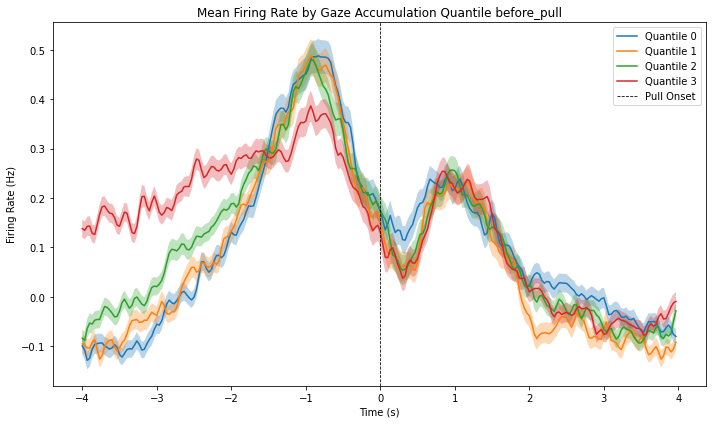

In [369]:
# step 1 - 2:
# do a basic plot for sanity check - mean FR across all units in the pool condition for each quantile
if 1:
    
    doQuantMeanFRs = 1
    
    timewins = np.arange(-4, 4, 1/30)
    n_timepoints = len(timewins)
    if doQuantMeanFRs:
        quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col].unique())
    else:
        quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[quantile_col].unique())

    y_label = 'Firing Rate (Hz)'
    
    fig, ax = plt.subplots(figsize=(10, 6))

    for i_quantile, q_val in enumerate(quantile_values):
        if doQuantMeanFRs:
            ind_quantile = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col] == q_val
            fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[ind_quantile]['mean_FR_trace'].tolist())
        else:
            ind_quantile = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[quantile_col] == q_val
            fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_quantile]['FR_ievent'].tolist())

        mean_fr = np.nanmean(fr_traces_quantile, axis=0)
        sem_fr = np.nanstd(fr_traces_quantile, axis=0) / np.sqrt(np.sum(~np.isnan(fr_traces_quantile[:, 0]))) # Standard Error of the Mean

        ax.plot(timewins, mean_fr, label=f'Quantile {int(q_val)}')
        ax.fill_between(timewins, mean_fr - sem_fr, mean_fr + sem_fr, alpha=0.3)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel(y_label)
    ax.set_title(f'Mean Firing Rate by {title_prefix} Quantile '+gaze_duration_type)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.8, label='Pull Onset')
    ax.legend()
    fig.tight_layout()
    plt.show()

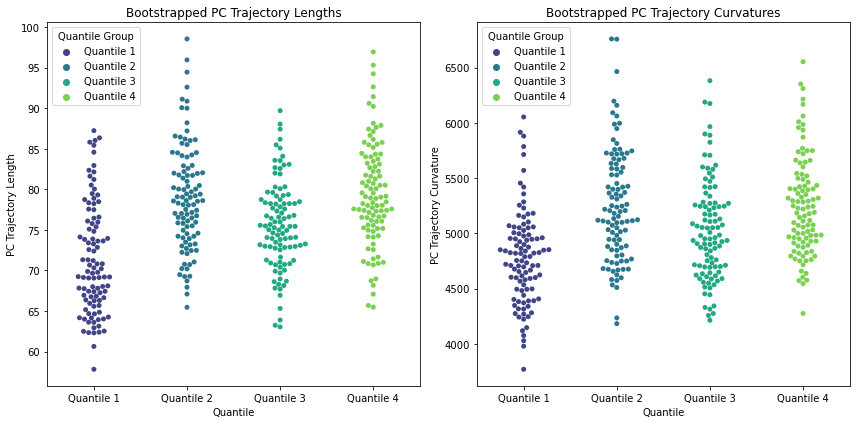

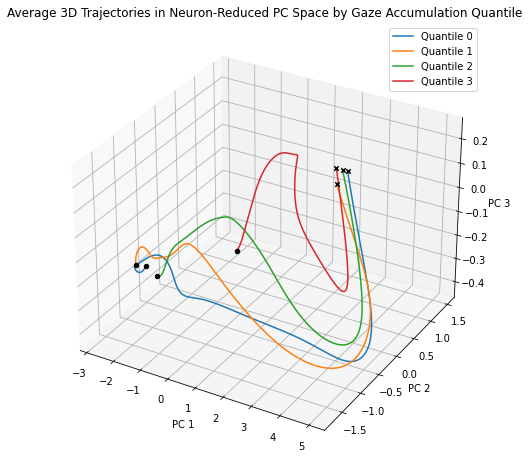


--- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---

Pairwise Paired t-tests for Length:
  Comparison       p_value   p_corrected  reject_null
0     (0, 1)  2.145437e-24  1.072718e-23         True
1     (0, 2)  8.212579e-13  1.642516e-12         True
2     (0, 3)  9.700285e-32  5.820171e-31         True
3     (1, 2)  7.700655e-14  2.310196e-13         True
4     (1, 3)  4.427301e-01  4.427301e-01        False
5     (2, 3)  2.073112e-15  8.292447e-15         True

Pairwise Paired t-tests for Curvature:
  Comparison       p_value   p_corrected  reject_null
0     (0, 1)  7.362913e-19  3.681457e-18         True
1     (0, 2)  5.325426e-08  1.597628e-07         True
2     (0, 3)  4.841437e-20  2.904862e-19         True
3     (1, 2)  6.020563e-08  1.597628e-07         True
4     (1, 3)  8.825579e-01  8.825579e-01        False
5     (2, 3)  3.685143e-08  1.474057e-07         True


In [370]:
# Step 2 - calculate the PCA with the pooled data

from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison

if 1:
    timewins = np.arange(-4, 4, 1 / 30)
    n_timepoints = len(timewins)
    quantile_col = 'gaze_accum_quantile'  # Or 'gaze_duration_quantile'
    y_label = 'Firing Rate (Hz)'
    title_prefix = 'Gaze Accumulation'  # Or 'Gaze Duration'
    smooth_kernel_size = 6
    n_bootstrap_iterations = 100
    n_neurons_to_sample = 100
    
    # Get unique neurons
    unique_neurons = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[['clusterID', 'session']].drop_duplicates()
    n_neurons = len(unique_neurons)

    # Get unique quantiles
    unique_quantiles = np.sort(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col].unique())
    n_quantiles = len(unique_quantiles)

    # Initialize the data matrix
    data_matrix = np.empty((n_neurons, n_timepoints * n_quantiles))
    neuron_index_lookup = {}

    # Populate the data matrix
    neuron_counter = 0
    for neuron_row in unique_neurons.itertuples(index=False):
        cluster_id = neuron_row.clusterID
        session = neuron_row.session
        neuron_index_lookup[(cluster_id, session)] = neuron_counter
        neuron_counter += 1

        for i_quantile, q_val in enumerate(unique_quantiles):
            # Get the mean FR trace for the current neuron and quantile
            mean_fr_trace_df = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df['clusterID'] == cluster_id) &
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df['session'] == session) &
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col] == q_val)
            ]

            if not mean_fr_trace_df.empty:
                mean_fr_trace = mean_fr_trace_df['mean_FR_trace'].values[0]  # Take the first element
                data_matrix[neuron_index_lookup[(cluster_id, session)], i_quantile * n_timepoints:(i_quantile + 1) * n_timepoints] = mean_fr_trace
            else:
                data_matrix[neuron_index_lookup[(cluster_id, session)], i_quantile * n_timepoints:(i_quantile + 1) * n_timepoints] = np.nan  # Handle missing data

    # Prepare to store results
    all_quantile_lengths = np.zeros((n_bootstrap_iterations, n_quantiles))
    all_quantile_curvatures = np.zeros((n_bootstrap_iterations, n_quantiles))
    all_boot_pca_data = np.zeros((n_bootstrap_iterations, 10, n_timepoints * n_quantiles))  # Store all PCA results

    # Perform Bootstrapping
    for boot_iter in range(n_bootstrap_iterations):
        # 1. Randomly sample neurons
        sampled_neuron_indices = np.random.choice(n_neurons, n_neurons_to_sample, replace=True)
        sampled_data_matrix = data_matrix[sampled_neuron_indices, :].transpose()  # Neuron dimension becomes the columns

        # 2. Run PCA
        pca = PCA(n_components=10)  # Project to 10 PCs
        pca.fit(np.nan_to_num(sampled_data_matrix))
        pca_data = pca.transform(np.nan_to_num(sampled_data_matrix)).transpose()  # Project and transpose
        all_boot_pca_data[boot_iter, :, :] = pca_data

        # Calculate length and curvature for each quantile
        for i_quantile, q_val in enumerate(unique_quantiles):
            start_col = i_quantile * n_timepoints
            end_col = (i_quantile + 1) * n_timepoints
            quantile_data = pca_data[:, start_col:end_col]  # (10, n_timepoints)

            # 
            if gaze_duration_type == 'around_pull':
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, :], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, :], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors
            #
            elif gaze_duration_type == 'before_pull':
                ind_tgt = timewins<0
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, ind_tgt], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, ind_tgt], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors
            #
            elif gaze_duration_type == 'after_pull':
                ind_tgt = timewins>0
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, ind_tgt], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, ind_tgt], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors
                

    # --- Plotting ---
    # Plot Length and Curvature (as before)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Create a Pandas DataFrame for easier plotting with Seaborn
    df = pd.DataFrame(all_quantile_lengths, columns=[f'Quantile {i+1}' for i in range(num_quantiles)])
    # Melt the DataFrame to long format, which is ideal for Seaborn
    df_melted = pd.melt(df, var_name='Quantile Group', value_name='Length')
    # Create the swamp plot (also known as a violin plot)
    seaborn.swarmplot(ax = axes[0], x='Quantile Group', y='Length', data=df_melted, 
                      hue='Quantile Group', palette='viridis')
    #axes[0].boxplot(all_quantile_lengths)
    # axes[0].set_xticks(np.arange(1, n_quantiles + 1))
    axes[0].set_xlabel('Quantile')
    axes[0].set_ylabel('PC Trajectory Length')
    axes[0].set_title('Bootstrapped PC Trajectory Lengths')

    # Create a Pandas DataFrame for easier plotting with Seaborn
    df = pd.DataFrame(all_quantile_curvatures, columns=[f'Quantile {i+1}' for i in range(num_quantiles)])
    # Melt the DataFrame to long format, which is ideal for Seaborn
    df_melted = pd.melt(df, var_name='Quantile Group', value_name='Length')
    # Create the swamp plot (also known as a violin plot)
    seaborn.swarmplot(ax = axes[1], x='Quantile Group', y='Length', data=df_melted, 
                      hue='Quantile Group', palette='viridis')
    # axes[1].boxplot(all_quantile_curvatures)
    # axes[1].set_xticks(np.arange(1, n_quantiles + 1))
    axes[1].set_xlabel('Quantile')
    axes[1].set_ylabel('PC Trajectory Curvature')
    axes[1].set_title('Bootstrapped PC Trajectory Curvatures')

    plt.tight_layout()
    plt.show()

    # Plot Average 3D Traces
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    mean_traces_3d = np.mean(all_boot_pca_data[:, :3, :], axis=0)  # Average across bootstrap iterations, use only first 3 PCs

    for i_quantile, q_val in enumerate(unique_quantiles):
        start_col = i_quantile * n_timepoints
        end_col = (i_quantile + 1) * n_timepoints
        mean_quantile_data = mean_traces_3d[:, start_col:end_col]

        # Smooth the trajectory
        smooth_x = gaussian_filter1d(mean_quantile_data[0, ind_tgt], sigma=smooth_kernel_size)
        smooth_y = gaussian_filter1d(mean_quantile_data[1, ind_tgt], sigma=smooth_kernel_size)
        smooth_z = gaussian_filter1d(mean_quantile_data[2, ind_tgt], sigma=smooth_kernel_size)

        # Plot the smoothed trajectory
        ax.plot(smooth_x, smooth_y, smooth_z, label=f'Quantile {int(q_val)}')

        # Mark start and end points
        ax.scatter(smooth_x[0], smooth_y[0], smooth_z[0], marker='o', color='k')  # Start
        ax.scatter(smooth_x[-1], smooth_y[-1], smooth_z[-1], marker='x', color='k')  # End

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'Average 3D Trajectories in Neuron-Reduced PC Space by {title_prefix} Quantile')
    ax.legend()
    plt.show()

    # --- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---
    print("\n--- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---")

    from scipy import stats
    from statsmodels.sandbox.stats.multicomp import multipletests

    def perform_pairwise_paired_ttests(data, group_labels, alpha=0.01):
        unique_groups = np.unique(group_labels)
        n_groups = len(unique_groups)
        p_values = []
        comparisons = []

        for i in range(n_groups):
            for j in range(i + 1, n_groups):
                group1_data = data[:, i]
                group2_data = data[:, j]
                t_stat, p_val = stats.ttest_rel(group1_data, group2_data)
                p_values.append(p_val)
                comparisons.append((unique_groups[i], unique_groups[j]))

        reject, p_corrected, _, _ = multipletests(p_values, method='holm', alpha=alpha)

        results_df = pd.DataFrame({'Comparison': comparisons,
                                   'p_value': p_values,
                                   'p_corrected': p_corrected,
                                   'reject_null': reject})
        return results_df

    # Perform pairwise paired t-tests for Length
    length_pairwise_results = perform_pairwise_paired_ttests(all_quantile_lengths, unique_quantiles)
    print("\nPairwise Paired t-tests for Length:")
    print(length_pairwise_results)

    # Perform pairwise paired t-tests for Curvature
    curvature_pairwise_results = perform_pairwise_paired_ttests(all_quantile_curvatures, unique_quantiles)
    print("\nPairwise Paired t-tests for Curvature:")
    print(curvature_pairwise_results)